<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/DLL_HW__4__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 4  |  Современные сверточные архитектуры

## Иванов Денис

### Задача:

Датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels


1.Обучите модели ResNet 18 и VGG 16 с нуля (5-10 эпох)

2.Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)

3.Добавьте аугментацию данных к пункту 2

Сравните качество всех 3 полученных подходов

4.Примените FineTuning ResNet 18 к FashionMnist. 

In [1]:
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets, models, transforms
import torch.optim as optim
import time

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [3]:
import os
import sys
from google.colab import drive 

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive



DataSet

In [8]:
data_transforms = {
    'train':tv.transforms.Compose(  [
            tv.transforms.CenterCrop(224),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]),
    'val': tv.transforms.Compose(   [
            tv.transforms.Resize(256),
            tv.transforms.CenterCrop(224),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]),
                    }


data_dir = '/content/drive/My Drive/DLL/hymenoptera_data/'

image_datasets = {x: tv.datasets.ImageFolder(os.path.join(data_dir, x),
                                             data_transforms[x])
                  for x in ['train', 'val']}

dataloaders    = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=18, #24
                                              shuffle=True
                                              )
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dataloaders['train'], dataloaders['val']

(<torch.utils.data.dataloader.DataLoader at 0x7ff1c97f2050>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff1c8d9db50>)

In [ ]:
image_datasets['train'][0][0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


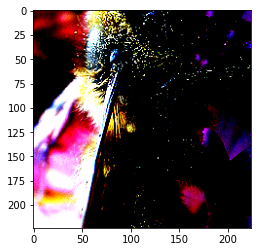

bees


In [ ]:
image,label = image_datasets['train'][221]
plt.imshow(image.permute(2,1,0))
plt.show()
print(image_datasets['train'].classes[label])

In [13]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [14]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            #print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
             #   (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

1.1.  ResNet 18 с нуля

In [ ]:
model_resnet_0 = models.resnet18()

In [ ]:
model_resnet_0 = model_resnet_0.to(dev)

In [ ]:
print(model_resnet_0)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_resnet_0.fc = nn.Linear(in_features=512, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(model_resnet_0.parameters(), lr=lr)
train(model_resnet_0, dataloaders['train'], dataloaders['val'], 
      trainer, num_epochs, dev)

epoch 1, loss 0.6919, train acc 0.586, test acc 0.464, time 5.9 sec
epoch 2, loss 0.7100, train acc 0.574, test acc 0.556, time 5.5 sec
epoch 3, loss 0.6044, train acc 0.684, test acc 0.647, time 5.5 sec
epoch 4, loss 0.5670, train acc 0.734, test acc 0.654, time 5.5 sec
epoch 5, loss 0.5402, train acc 0.693, test acc 0.680, time 5.5 sec


In [ ]:
torch.cuda.empty_cache()

1.2.  VGG16 с нуля

In [ ]:
model_vgg_0 = models.vgg16()

In [ ]:
model_vgg_0 = model_vgg_0.to(dev)

In [ ]:
print(model_vgg_0)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_vgg_0.classifier._modules['6'] = nn.Linear(4096, 2).to(dev)

In [ ]:
lr, num_epochs = 0.000001, 6
trainer = torch.optim.Adam(model_vgg_0.parameters(), lr=lr)
train(model_vgg_0, dataloaders['train'], dataloaders['val'], 
      trainer, num_epochs, dev)

epoch 1, loss 0.7036, train acc 0.426, test acc 0.451, time 14.1 sec
epoch 2, loss 0.6924, train acc 0.516, test acc 0.523, time 14.0 sec
epoch 3, loss 0.6899, train acc 0.627, test acc 0.542, time 14.1 sec
epoch 4, loss 0.6874, train acc 0.619, test acc 0.542, time 14.0 sec
epoch 5, loss 0.6856, train acc 0.611, test acc 0.542, time 14.0 sec
epoch 6, loss 0.6829, train acc 0.668, test acc 0.569, time 14.1 sec


2.1. Resnet18 - pretrained model

In [ ]:
model_resnet_pt = models.resnet18(pretrained=True).to(dev)

In [ ]:
for param in model_resnet_pt.parameters():
    param.requires_grad = False

In [ ]:
model_resnet_pt.fc = nn.Linear(in_features=512, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.00035, 10
trainer = torch.optim.Adam(model_resnet_pt.parameters(), lr=lr)
train(model_resnet_pt, dataloaders['train'], dataloaders['val'], 
      trainer, num_epochs, dev)

epoch 1, loss 0.6782, train acc 0.594, test acc 0.712, time 5.0 sec
epoch 2, loss 0.5330, train acc 0.787, test acc 0.843, time 4.9 sec
epoch 3, loss 0.4310, train acc 0.877, test acc 0.876, time 5.0 sec
epoch 4, loss 0.3595, train acc 0.910, test acc 0.895, time 5.0 sec
epoch 5, loss 0.3096, train acc 0.930, test acc 0.908, time 5.0 sec
epoch 6, loss 0.2760, train acc 0.934, test acc 0.922, time 5.0 sec
epoch 7, loss 0.2463, train acc 0.939, test acc 0.915, time 5.0 sec
epoch 8, loss 0.2239, train acc 0.947, test acc 0.935, time 5.0 sec
epoch 9, loss 0.2065, train acc 0.947, test acc 0.941, time 5.0 sec
epoch 10, loss 0.1909, train acc 0.951, test acc 0.948, time 4.9 sec


2.2. VGG16 - pretrained model

In [ ]:
model_vgg_pt = models.vgg16(pretrained=True).to(dev)

In [ ]:
## Убираем требование градиента:
for param in model_vgg_pt.parameters():
    param.requires_grad = False

In [ ]:
model_vgg_pt.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model_vgg_pt.classifier[6] = nn.Linear(in_features=4096, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.00004, 8
trainer = torch.optim.Adam(model_vgg_pt.parameters(), lr=lr)
train(model_vgg_pt, dataloaders['train'], dataloaders['val'],
      trainer, num_epochs, dev)

epoch 1, loss 0.7375, train acc 0.512, test acc 0.614, time 8.1 sec
epoch 2, loss 0.5885, train acc 0.717, test acc 0.824, time 8.1 sec
epoch 3, loss 0.4970, train acc 0.840, test acc 0.915, time 8.0 sec
epoch 4, loss 0.4256, train acc 0.893, test acc 0.928, time 7.9 sec
epoch 5, loss 0.3706, train acc 0.930, test acc 0.941, time 8.0 sec
epoch 6, loss 0.3291, train acc 0.939, test acc 0.948, time 8.1 sec
epoch 7, loss 0.2963, train acc 0.943, test acc 0.948, time 8.0 sec
epoch 8, loss 0.2709, train acc 0.947, test acc 0.954, time 8.0 sec


3. Augmentation

In [ ]:
data_transforms_aug = {
    'train':tv.transforms.Compose(  [
            tv.transforms.RandomHorizontalFlip(),
            tv.transforms.RandomVerticalFlip(),
            tv.transforms.RandomResizedCrop(
                    (224, 224), scale=(0.8, 1), ratio=(0.8, 1.2)),
            tv.transforms.CenterCrop(224),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]),
    'val': tv.transforms.Compose(   [
            tv.transforms.Resize(256),
            tv.transforms.CenterCrop(224),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]),
                    }

image_datasets_aug = {x: tv.datasets.ImageFolder(os.path.join(data_dir, x),
                                                 data_transforms_aug[x])
                  for x in ['train', 'val']}


dataloaders_aug    = {x: torch.utils.data.DataLoader(image_datasets_aug[x], 
                                                    batch_size=18, 
                                                    shuffle=True
                                                    )
                  for x in ['train', 'val']}

3.1. Resnet18 - pretrained model + aug

In [ ]:
model_resnet_pt_aug = models.resnet18(pretrained=True).to(dev)

In [ ]:
for param in model_resnet_pt_aug.parameters():
    param.requires_grad = False

In [ ]:
model_resnet_pt_aug.fc = nn.Linear(in_features=512, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.0002, 15
trainer = torch.optim.Adam(model_resnet_pt_aug.parameters(), lr=lr)
train(model_resnet_pt_aug, 
      dataloaders_aug['train'], dataloaders_aug['val'], 
      trainer, num_epochs, dev)

epoch 1, loss 0.7471, train acc 0.500, test acc 0.588, time 5.1 sec
epoch 2, loss 0.6271, train acc 0.607, test acc 0.699, time 5.0 sec
epoch 3, loss 0.5529, train acc 0.705, test acc 0.771, time 5.0 sec
epoch 4, loss 0.4996, train acc 0.799, test acc 0.850, time 5.0 sec
epoch 5, loss 0.4456, train acc 0.844, test acc 0.876, time 5.0 sec
epoch 6, loss 0.4007, train acc 0.881, test acc 0.915, time 4.9 sec
epoch 7, loss 0.3690, train acc 0.902, test acc 0.915, time 4.9 sec
epoch 8, loss 0.3453, train acc 0.906, test acc 0.928, time 4.9 sec
epoch 9, loss 0.3196, train acc 0.930, test acc 0.935, time 4.9 sec
epoch 10, loss 0.3013, train acc 0.943, test acc 0.941, time 5.0 sec
epoch 11, loss 0.2737, train acc 0.959, test acc 0.948, time 4.9 sec
epoch 12, loss 0.2687, train acc 0.947, test acc 0.948, time 4.9 sec
epoch 13, loss 0.2602, train acc 0.934, test acc 0.948, time 4.9 sec
epoch 14, loss 0.2465, train acc 0.963, test acc 0.954, time 4.8 sec
epoch 15, loss 0.2334, train acc 0.951, tes

3.2. VGG16 - pretrained model + aug

In [ ]:
model_vgg_pt_aug = models.vgg16(pretrained=True).to(dev)

In [ ]:
for param in model_vgg_pt_aug.parameters():
    param.requires_grad = False

In [ ]:
model_vgg_pt_aug.classifier[6] = nn.Linear(in_features=4096, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.00001, 15
trainer = torch.optim.Adam(model_vgg_pt_aug.parameters(), lr=lr)
train(model_vgg_pt_aug, 
      dataloaders_aug['train'], dataloaders_aug['val'],
      trainer, num_epochs, dev)

epoch 1, loss 0.7860, train acc 0.488, test acc 0.634, time 7.9 sec
epoch 2, loss 0.6789, train acc 0.619, test acc 0.647, time 7.8 sec
epoch 3, loss 0.6631, train acc 0.611, test acc 0.693, time 7.8 sec
epoch 4, loss 0.6331, train acc 0.631, test acc 0.725, time 7.8 sec
epoch 5, loss 0.6023, train acc 0.680, test acc 0.752, time 7.8 sec
epoch 6, loss 0.5841, train acc 0.705, test acc 0.778, time 7.8 sec
epoch 7, loss 0.5532, train acc 0.787, test acc 0.797, time 7.8 sec
epoch 8, loss 0.5356, train acc 0.762, test acc 0.830, time 7.8 sec
epoch 9, loss 0.5151, train acc 0.787, test acc 0.869, time 7.9 sec
epoch 10, loss 0.4892, train acc 0.836, test acc 0.889, time 7.8 sec
epoch 11, loss 0.4771, train acc 0.865, test acc 0.902, time 7.8 sec
epoch 12, loss 0.4568, train acc 0.881, test acc 0.922, time 7.8 sec
epoch 13, loss 0.4312, train acc 0.877, test acc 0.922, time 7.8 sec
epoch 14, loss 0.4282, train acc 0.898, test acc 0.928, time 7.8 sec
epoch 15, loss 0.4122, train acc 0.889, tes

4. FineTuning ResNet 18 для FashionMnist.

In [4]:
from torchvision.datasets import FashionMNIST

In [25]:
BATCH_SIZE = 64

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

train_iter = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                          shuffle=True)

testset = FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

test_iter = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, 
                                         shuffle=False)

In [26]:
model_fm_resnet_pt_aug = models.resnet18(pretrained=True)

In [27]:
for param in model_fm_resnet_pt_aug.parameters():
    param.requires_grad = False

In [ ]:
model_fm_resnet_pt_aug.fc = nn.Linear(in_features=512, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.0002, 15
trainer = torch.optim.Adam(model_fm_resnet_pt_aug.parameters(), lr=lr)
train(model_fm_resnet_pt_aug, 
      train_iter, test_iter, 
      trainer, num_epochs, dev)